# Projeto 7 - Leonardo Malta 

In [20]:
from numpy.lib.shape_base import column_stack
from suaBibSignal import *
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import pandas as pd
from suaBibSignal import *
import sys
from sys import byteorder
from array import array
from struct import pack
import pyaudio
import wave

## Criando tabela DTMF

In [21]:
teclado = {}
teclado["Freq"] = [697, 770, 852, 941]
teclado[1209] = ["1", "4", "7", "X"]
teclado[1336] = ["2", "5", "8", "0"]
teclado[1477] = ["3", "6", "9", "#"]
teclado[1633] = ["A", "B", "C", "D"]
tabela_teclado = pd.DataFrame(teclado).set_index("Freq")

tabela_teclado

,1209,1336,1477,1633
Freq,,,,
697,1,2,3,A
770,4,5,6,B
852,7,8,9,C
941,X,0,#,D


## Funções Úteis

In [22]:
def frequencies(key):
    for index, values in tabela_teclado.items():
        for element in values:
            if element == key:
                maior = index

    menor = tabela_teclado.index[tabela_teclado[maior] == key].tolist()[0]
    
    return menor, maior

#funções a serem utilizadas
def signal_handler(signal, frame):
        print('You pressed Ctrl+C!')
        sys.exit(0)


#converte intensidade em Db, caso queiram ...
def todB(s):
    sdB = 10*np.log10(s)
    return(sdB)

## Gravar audio

In [23]:
# Referência: https://stackoverflow.com/questions/892199/detect-record-audio-in-python
THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    silence = [0] * int(seconds * RATE)
    r = array('h', silence)
    r.extend(snd_data)
    r.extend(silence)
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 30:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

## Constantes do Projeto

In [24]:
fs = 44100
A = 1
T = 1

In [25]:
bib_signal = signalMeu()
sd.default.samplerate = fs
sd.default.channels = 1 #Tipicamente são 2. Placas com dois canais. Se ocorrer problemas pode tentar com1.

## Função do enconde (Emissor)

In [26]:
def encode():
    key = input('Qual tecla você deseja apertar? ')
    freq1, freq2 = frequencies(key)
    print(f'Freqências retornadas: {freq1} e {freq2}')

    x1, s1 = bib_signal.generateSin(freq1, A, T, fs)
    x2, s2 = bib_signal.generateSin(freq2, A, T, fs)
    s3 = s1 + s2

    print(s3)

    som_gravado = []
    for value in s3:
        som_gravado.append(str(value))

    sd.play(s3, fs)

    bib_signal.plotSignal(key, s3, T, fs)
    bib_signal.plotFFT(s3, fs)
    sd.wait()

    with open(f"signal.txt", "w") as file:
        file.write(" ".join(som_gravado))

## Função do decoder (receptor)

In [27]:
def decode():
    numAmostras = T*fs
    
    # audio = sd.rec(int(numAmostras), fs, channels=1) # Usar para gravar saída de áudio do pc 

    with open("signal.txt", "r") as file:
        record = file.read()
    
    # https://python-sounddevice.readthedocs.io/en/0.3.7/
    key_bip = []
    for value in record.split(" "):
        key_bip.append(float(value))

    key_bip = np.array(key_bip)
    
    bib_signal.plotRecieved(key_bip, T, fs)
    bib_signal.plotFFT(key_bip, fs)
    
    sd.play(key_bip, fs)
    sd.wait()


## Plotando gráficos e gerando som da tecla (Encode)

Qual tecla você deseja apertar? A
Freqências retornadas: 697 e 1633
[ 0.00000000e+00  3.29719567e-01  6.46036308e-01 ... -6.46036308e-01
 -3.29719567e-01  2.39333310e-13]


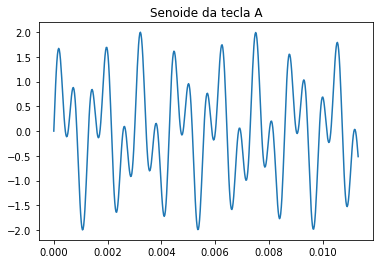

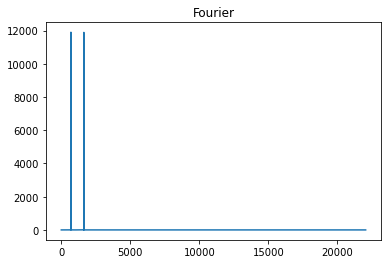

In [35]:
encode()

##  Grava o som

In [29]:
record_to_file('demo.wav')

## Recebendo sinal e plotando gráficos (decoder)

In [30]:
# decode()